In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [3]:
df = pd.read_csv('../Data/digital_marketing_campaign_dataset.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/digital_marketing_campaign_dataset.csv'

In [31]:
print("========== Missing Values ==========")
print(df.isnull().sum())

print("========== Duplicate Values ==========")
print(df.duplicated().sum())

========== Missing Values ==========
CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64
========== Duplicate Values ==========
0


In [34]:
print(df['CampaignChannel'].unique())
print(df['CampaignType'].unique())


['Social Media' 'Email' 'PPC' 'Referral' 'SEO']
['Awareness' 'Retention' 'Conversion' 'Consideration']


Data Cleaning

Our personalised marketing efforts in this case involves 
1. email and PPC for targeted ads
2. Social Media for brand awareness and customer engagement
3. Referral for acquiring customers through existing clients
4. SEO to improve search visibility and credibility

During our marketing campaign, we ran different campaign types to promote our product and services:
Awareness: When banks aim to introduce their services to potential customers, creating brand visibility.
Consideration: When potential customers start evaluating banking options, researching products and benefits.
Conversion: When customers are ready to act, applying for a product or opening an account.
Retention: When banks focus on keeping existing customers engaged and satisfied, fostering loyalty.

In [150]:
# dropping information redundant to our campaign which will help us calculate ROI
df.drop(
    columns=[
        'AdvertisingTool',
        'AdvertisingPlatform',
        'PagesPerVisit',
        'EmailOpens',
        'WebsiteVisits',
        'TimeOnSite',
        'SocialShares',
        'ClickThroughRate'],
    inplace=True
)

In [36]:
df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Income                 int64
CampaignChannel       object
CampaignType          object
AdSpend              float64
ClickThroughRate     float64
ConversionRate       float64
EmailClicks            int64
PreviousPurchases      int64
LoyaltyPoints          int64
Conversion             int64
dtype: object

In this case we decided to keep the relevant stages of conversion and retention, which are relevant for measuring and maximizing ROI of our marketing efforts

Conversion: This stage directly impacts ROI because it focuses on customer actions, such as applying for a product or opening an account. It is the most immediate driver of revenue and is essential for calculating the effectiveness of marketing spend in acquiring new customers.

Retention: Retaining customers can improve lifetime value, which is a crucial factor for maximizing ROI. Engaged and loyal customers are more likely to make additional purchases, use more services, or even refer new customers, thereby enhancing long-term revenue.

In [151]:
df_marketing = df[df['CampaignType'].isin(['Conversion', 'Retention'])]
df_marketing

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,7,2,3459,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6,8,4345,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,3,0,2983,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,8,5,460,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,0,0,2935,0
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,5,3,3075,1
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,0,5,2733,0
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,1,7,3066,0


In [40]:
df_marketing.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,11984.893390,44.011680,84568.041750,4987.186666,0.155864,0.104061,4.484841,4.530815,2480.162525,0.897117
std,2293.596494,14.822644,37395.411917,2846.222990,0.084372,0.054973,2.856980,2.890158,1423.547374,0.303843
min,8001.000000,18.000000,20057.000000,103.956957,0.010052,0.010020,0.000000,0.000000,1.000000,0.000000
25%,9985.750000,32.000000,51917.000000,2472.063139,0.082999,0.056163,2.000000,2.000000,1257.500000,1.000000
50%,12000.000000,44.000000,84526.500000,5039.892169,0.156490,0.103603,4.000000,5.000000,2471.500000,1.000000
75%,13934.000000,57.000000,116432.750000,7432.776248,0.229350,0.150915,7.000000,7.000000,3676.000000,1.000000
max,15996.000000,69.000000,149986.000000,9997.914781,0.299788,0.199995,9.000000,9.000000,4999.000000,1.000000


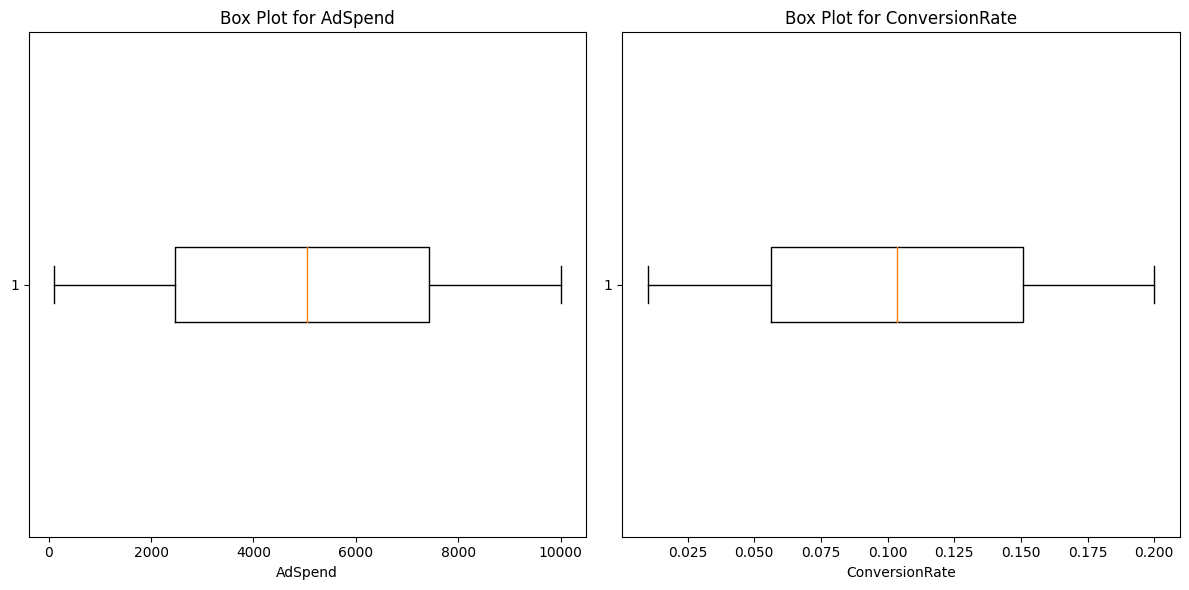

In [68]:
# Checking for outliers in the case of income, adspend and timeonesite
columns = ['AdSpend', 'ConversionRate']

# Set up the plot
plt.figure(figsize=(12, 6))

# Generate a box plot for each column
for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)
    plt.boxplot(df_marketing[column].dropna(), vert=False)
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


The box plots reveal that AdSpend, Income, and TimeOnSite have well-distributed values with no outliers. This will help to ensure that the analysis of ROI for personalized marketing efforts reflects typical customer behavior and avoids misleading extremes. This help ensure that our model will have more reliable predictions later on, without the need for outlier handling.

Feature Engineering step

Proceed to perform feature engineering to calculate
1. ROI
Our average revenue per conversion is taken from overall value earned from our banking clients particularly in areas like private banking, mortgages, corporate banking, and investment accounts, amoutning to 60,000.

Our ROI here is calculated: Total Revenue - Total Ad Spend / Total Ad Spend
Where totla revenue is the conversion rate of each customer * 60,000 (average revenue per conversion)

2. Customer Lifetime value
Total revenue a business can expect from a customer, adjusted by factors like loyalty points and conversion metrics.

CLV focuses on average revenue per conversion, multiplied by expected purchase frequency within a chosen period (e.g., a year). 

3. Conversion Rates
Recorded in the dataset

4. Campaign costs
Represented by Ad spend

In [153]:
avg_revenue_per_conversion = 60000

# Calculate estimated revenue from conversion rate and average revenue per conversion
df_marketing.loc[:,'Revenue'] = df_marketing['ConversionRate'] * avg_revenue_per_conversion
df_marketing.loc[:,'ROI'] = (df_marketing['Revenue'] - df_marketing['AdSpend']) / df_marketing['AdSpend'] 

# Calculate CLV, assuming a standard period of 1 year
df_marketing.loc[:,'CLV'] = (avg_revenue_per_conversion + df_marketing['LoyaltyPoints']) * df_marketing['PreviousPurchases']

df_marketing

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Revenue,ROI,CLV
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,7,2,3459,1,10963.48098,1.812109,126918
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,2,0,2463,1,5280.25122,8.786835,0
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6,8,4345,1,6596.40618,2.931010,514760
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,3,0,2983,1,11336.75550,1.129255,0
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,8,5,460,1,6755.10066,-0.282993,302300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,0,0,2935,0,10981.84434,38.506508,0
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,5,3,3075,1,2824.75710,-0.538353,189225
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,0,5,2733,0,4104.17598,1.027606,313665
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,1,7,3066,0,10474.92798,0.502187,441462


In [83]:
df_marketing.CampaignChannel.value_counts()


CampaignChannel
Referral        881
PPC             839
SEO             791
Email           776
Social Media    737
Name: count, dtype: int64

Label encoding for non-numerical columns

In [154]:
# Initialize label encoders
gender_encoder = LabelEncoder()
campaign_type_encoder = LabelEncoder()


# Dropping the CustomerID
df_marketing = df_marketing.drop(columns=['CustomerID'])


# Apply label encoding 
df_marketing.loc[:,'Gender'] = gender_encoder.fit_transform(df_marketing['Gender'])
df_marketing.loc[:,'CampaignType'] = campaign_type_encoder.fit_transform(df_marketing['CampaignType'])


df_marketing

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Revenue,ROI,CLV
1,69,1,41760,Email,1,3898.668606,0.182725,7,2,3459,1,10963.48098,1.812109,126918
3,32,0,44085,PPC,0,539.525936,0.088004,2,0,2463,1,5280.25122,8.786835,0
4,60,0,83964,PPC,0,1678.043573,0.109940,6,8,4345,1,6596.40618,2.931010,514760
7,56,0,57083,Social Media,0,5324.283667,0.188946,3,0,2983,1,11336.75550,1.129255,0
8,36,0,140788,Email,1,9421.250951,0.112585,8,5,460,1,6755.10066,-0.282993,302300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,50,0,84079,PPC,1,277.975579,0.183031,0,0,2935,0,10981.84434,38.506508,0
7991,62,0,69289,SEO,1,6118.863881,0.047079,5,3,3075,1,2824.75710,-0.538353,189225
7992,37,1,138422,Referral,1,2024.148848,0.068403,0,5,2733,0,4104.17598,1.027606,313665
7993,20,1,120271,Social Media,1,6973.120174,0.174582,1,7,3066,0,10474.92798,0.502187,441462


Feature selection using random forest regressor

Reduce dimensions, overfitting rsik and also avoid more multicollinearity issues across the different features

In [160]:
X = df_marketing.drop(columns=['ROI', 'CampaignChannel'])  # features
y = df_marketing['ROI'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(7).index  
top_features

Index(['AdSpend', 'Revenue', 'ConversionRate', 'Income', 'LoyaltyPoints',
       'Age', 'CLV'],
      dtype='object')

Post Feature selection, we will begin training the model for each of our 5 marketing strategies to predict the ROI and performance.

I tried a few different regressor and models for prediction

In [198]:
from sklearn.neighbors import KNeighborsRegressor

marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()


# Conducting an analysis for each of the 
for strategy in marketing_strategies:

    print(f"========== {strategy} ==========")

    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)  


    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()


========== Email ==========
Mean Absolute Error (MAE): 0.3069933615079077
Root Mean Squared Error (RMSE): 1.4311934408913067
R2 Score: 0.9041860580884103
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.13274665563803967
Root Mean Squared Error (RMSE): 0.3553302585106352
R2 Score: 0.9908161928119874
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.6632345910854258
Root Mean Squared Error (RMSE): 3.1451185121547334
R2 Score: 0.7020186201602602
ROI Mean: 2.1971547087470658

========== Referral ==========
Mean Absolute Error (MAE): 0.7049339629293222
Root Mean Squared Error (RMSE): 3.1513798883405597
R2 Score: 0.7733999473127218
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.8135284295675594
Root Mean Squared Error (RMSE): 3.397518119901387
R2 Score: 0.6673332688966123
ROI Mean: 1.9732796784077806



Using Gradeint Boosting Regressor

In [190]:
from sklearn.ensemble import GradientBoostingRegressor

marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()


# Conducting an analysis for each of the 
for strategy in marketing_strategies:

    print(f"========== {strategy} ==========")

    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, max_depth=3, random_state=42)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()


========== Email ==========
Mean Absolute Error (MAE): 0.31778376025315636
Root Mean Squared Error (RMSE): 1.4103098903135292
R2 Score: 0.9069618348880016
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.16079781771008328
Root Mean Squared Error (RMSE): 0.36388342310331995
R2 Score: 0.9903687442225041
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.5022511529669563
Root Mean Squared Error (RMSE): 1.8524871357419068
R2 Score: 0.896622625354361
ROI Mean: 2.1971547087470658

========== Referral ==========
Mean Absolute Error (MAE): 0.4287148758649151
Root Mean Squared Error (RMSE): 1.8061841970044037
R2 Score: 0.9255640792822852
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.5484975920234934
Root Mean Squared Error (RMSE): 1.9487336477050918
R2 Score: 0.8905562978922268
ROI Mean: 1.9732796784077806

